# Předpověď kosmického počasí

Kosmický počasím se nazývá souhrn jevů v meziplanetárním prostředí, zejména parametry [slunečního větru](https://en.wikipedia.org/wiki/Solar_wind). Ty sleduje i síť družic GOES 
![GOES 14-15](goes_14-15.jpg)

Ty měří mimo jiné i tok částic od Slunce. NOAA zpřístupňuje [aktuální](https://www.swpc.noaa.gov/products/goes-electron-flux) i [historická měření](ftp://ftp.swpc.noaa.gov/pub/lists/particle/) na https://www.swpc.noaa.gov/.

![GOES electron flux](20180224_electron.gif)

Jedna z možností, jak celkem efektivně modelovat vývoj veličiny ke které nemáme vhodné regresory, je využít [**autoregresní model**](https://en.wikipedia.org/wiki/Autoregressive_model) p-tého řádu ve tvaru

$$
y_t = \beta_0 + \beta_1 y_{t-1} + ... = \beta_p y_{t-p} + \varepsilon_t = \beta^\intercal x_t + \varepsilon_t,
$$

kde $x_t = [1, y_{t-1}, \ldots, y_{t-p}]^{\intercal}$. Šum $\varepsilon_t$ budeme uvažovat normální iid.

Problematika autoregrese je poněkud složitější, nicméně si zkusíme sestavit model AR(1), tedy autoregresní model prvního řádu a ozkoušíme si na něm i tzv. **zapomínání**, což není nic jiného, než umělé zvyšování neurčitosti odhadu "zploštěním" apriorní (někdy aposteriorní) hustoty před vložením nových dat. To se dělá jednoduše umocněním:

$$
\left[\pi(\beta, \sigma^2|x_{0:t}, y_{0:t})\right]^\lambda, \qquad \lambda\in[0.95, 1],
$$

což při konjugovaném apriornu není nic jiného, než toto:

$$
\xi_{t-1} \leftarrow \lambda \xi_{t-1}, \qquad \nu_{t-1} \leftarrow \lambda\nu_{t-1}.
$$

# Datový soubor
    :Data_list: 20180225_Gp_part_5m.txt
    :Created: 2018 Feb 25 1536 UTC
    # Prepared by the U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center
    # Please send comments and suggestions to SWPC.Webmaster@noaa.gov 
    # 
    # Label: P > 1 = Particles at >1 Mev
    # Label: P > 5 = Particles at >5 Mev
    # Label: P >10 = Particles at >10 Mev
    # Label: P >30 = Particles at >30 Mev
    # Label: P >50 = Particles at >50 Mev
    # Label: P>100 = Particles at >100 Mev
    # Label: E>0.8 = Electrons at >0.8 Mev
    # Label: E>2.0 = Electrons at >2.0 Mev
    # Label: E>4.0 = Electrons at >4.0 Mev
    # Units: Particles = Protons/cm2-s-sr
    # Units: Electrons = Electrons/cm2-s-sr
    # Source: GOES-15
    # Location: W135
    # Missing data: -1.00e+05
    #
    #                      5-minute  GOES-15 Solar Particle and Electron Flux
    #
    #                 Modified Seconds
    # UTC Date  Time   Julian  of the
    # YR MO DA  HHMM    Day     Day     P > 1     P > 5     P >10     P >30     P >50     P>100     E>0.8     E>2.0     E>4.0
     #-------------------------------------------------------------------------------------------------------------------------
    2018 02 25  0000   58174      0   5.65e+00  1.61e-01  1.26e-01  6.80e-02  5.50e-02  2.82e-02  6.53e+04  1.58e+03 -1.00e+05
    2018 02 25  0005   58174    300   6.13e+00  2.19e-01  1.53e-01  8.97e-02  7.67e-02  4.99e-02  6.53e+04  1.57e+03 -1.00e+05
    2018 02 25  0010   58174    600   5.24e+00  2.21e-01  1.86e-01  1.28e-01  1.15e-01  4.75e-02  6.53e+04  1.54e+03 -1.00e+05
    2018 02 25  0015   58174    900   7.44e+00  2.56e-01  1.40e-01  6.80e-02  5.50e-02  2.82e-02  6.46e+04  1.50e+03 -1.00e+05
    2018 02 25  0020   58174   1200   5.25e+00  3.48e-01  3.12e-01  1.36e-01  1.02e-01  4.14e-02  6.37e+04  1.49e+03 -1.00e+05
    2018 02 25  0025   58174   1500   6.91e+00  2.82e-01  1.70e-01  9.89e-02  8.60e-02  5.91e-02  6.35e+04  1.48e+03 -1.00e+05
    2018 02 25  0030   58174   1800   4.80e+00  1.90e-01  1.54e-01  9.66e-02  8.37e-02  3.74e-02  6.26e+04  1.45e+03 -1.00e+05

Pustíme se do modelování a predikcí ve sloupci E>2, tedy elektrony s energií větší jak 2MeV. Použijeme pro jednoduchost AR(1) model

$$
y_t = \beta_0 + \beta_1 y_{t-1} + \varepsilon_t, \qquad \text{iid}\quad \varepsilon_t \sim\mathcal{N}(0, \sigma^2).
$$

Stejně jako u odhadu výšky využijeme NiG apriorno. Zajímat nás budou predikce.

In [1]:
import sys
sys.path.insert(0, '../zdrojaky/')

import numpy as np
import matplotlib.pylab as plt
from nig import NiG

Datový soubor je už stažen, tak jej jen natáhneme. Chová se podobně jako CSV (comma separated values), jen oddělovač jsou mezery. S tím si poradí _np.genfromtxt()_, musíme ale přeskočit preambuli (26 řádků).

In [2]:
#file = 'ftp://ftp.swpc.noaa.gov/pub/lists/particle/20180224_Gs_part_5m.txt'
datafile = '20180224_Gs_part_5m.txt'
data = np.genfromtxt(datafile, skip_header=26)
e2 = data[:,13]
ndat = e2.size

Zadefinujeme apriorní hyperparametry a zapomínací faktor *forg_factor*. Ten bývá obvykle mezi 0.95 a 1, přičemž hodnota 0.95 je považována za už dost nízkou.

In [3]:
xi0 = np.diag([1000, .1, .1])
nu0 = 5.
regmodel = NiG(xi0, nu0)

forg_factor = .95

Pustíme se do predikcí. Připomeňme, že odhady $\hat{\beta}$ najdeme v regmodel.Ebeta. Úkolem bude tyto odhady získat a napočítat predikce.

In [4]:
yt_pred = np.zeros(ndat)                        # sem budeme predikce ukládat

for t in range(3, ndat):
    #####################################
    # Místo *** vložte co je správně
    xt = np.array([1, e2[t-1]]) #e2 jsou ty data = y
    #####################################
    yt = e2[t]
   
    #####################################
    # Sem vložte kód na výpočet predikce
    yt_pred[t] = regmodel.Ebeta[0] + regmodel.Ebeta[1]*e2[t-1] = # regmodel.Ebeta.dot(xt)
    #####################################
    
    # zapomínání
    regmodel.xi *= forg_factor
    regmodel.nu *= forg_factor
    
    # update
    regmodel.update(yt, xt)
    regmodel.log()

Zajímat nás bude jen odhad $\hat{\beta}$ a predikce $\hat{y}_t$ vč. kvality predikce. Ta se měří často pomocí odmocniny kvadratické chyby RMSE (root mean squarred error):

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{T}\sum_{t=1}^{T}(\hat{y}_t - y_t)^2}.
$$

Vynecháme tolik dat, kolik jsme potřebovali, než jsme mohli AR model spustit (nešlo začít od prvního).

Vykreslíme si průběh i predikce a histogram s boxplotem chyb.

RMSE:  57.901021718


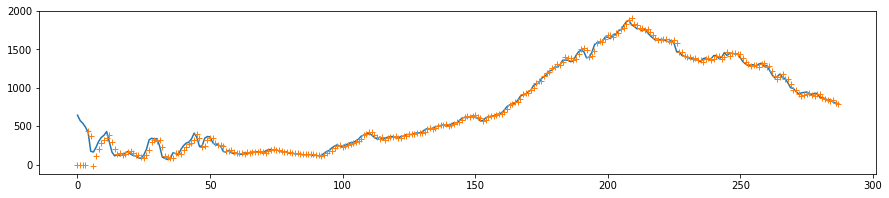

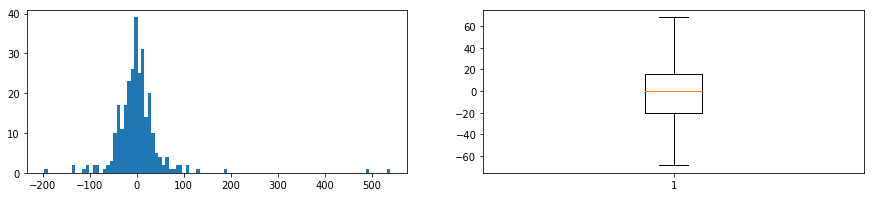

In [8]:
errors = e2[2:] - yt_pred[2:]

#####################################
# Zde doplňte řádek pro výpočet RMSE
RMSE = np.sqrt(np.mean(errors**2))
#####################################
print('RMSE: ', RMSE)

plt.figure(figsize=(15, 3))
plt.plot(e2)
plt.plot(yt_pred, '+')

plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.hist(errors, bins=100)
plt.subplot(1,2,2)
plt.boxplot(errors, showfliers=False)
plt.show()

A průběh odhadů $\hat{\beta}$:

In [ ]:
Ebeta_log = np.array(regmodel.Ebeta_log)
plt.figure(figsize=(15, 5))
plt.subplot(3, 1, 1)
plt.plot(Ebeta_log[:,0])
plt.subplot(3, 1, 2)
plt.plot(Ebeta_log[:,1])
plt.show()